## Analysis of Train to Busan Reviews

There are a few things I want to achieve through this analysis

I would like to 
* find similarities between reviews
* find keywords from the reviews
* get the average of reviews (/10)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import bs4 as bs
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim
import re
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from collections import Counter

## Web Scraping

In [2]:
path = r'C:\ProgramData\chocolatey\bin\chromedriver.exe'
driver = webdriver.Chrome(path)
driver.get('https://www.imdb.com/title/tt5700672/reviews?ref_=tt_ov_rt')

# on IMDb website, there aren't pages but load more buttons, so to grab the source code of all reviews, need to use selenium
while True:
    try:
        # load more until there is no more
        load_more = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'load-more-trigger'))
        )
        time.sleep(2)
        ActionChains(driver).move_to_element(load_more).click(load_more).perform()
    except:
        # store the source code of all reviews
        html = driver.page_source
        driver.quit()
        break

In [3]:
titles = []
ratings = []
reviews = []

# web scraping using BeautifulSoup
soup = bs.BeautifulSoup(html, 'lxml')
all_containers = soup.findAll('div', {'class':'lister-item-content'})
for container in all_containers:
    # title cannot be empty
    titles.append(container.a.text.strip())
    if container.div.span.span is None:
        ratings.append(np.nan)
    else:
        ratings.append(container.div.span.span.text)
    if container.findChildren('div')[2].div is None:
        reviews.append('None')
    else:
        reviews.append(container.findChildren('div')[2].div.text)

In [4]:
frame = {'Title':titles, 'Rating':ratings, 'Review':reviews}
review_df = pd.DataFrame(frame)
review_df['Rating'] = review_df['Rating'].astype('float')
# pd.set_option('display.max_rows', None)
review_df.head(10)

,Title,Rating,Review
0,Zombie Revival,8.0,Train to Busan was a treat. A look into Selfis...
1,Unforgettable experience! One of the best zomb...,9.0,Forget about the ordinary and immerse yourself...
2,The Best Zombie Movie To Date,10.0,"This movie did what I have not seen many, if a..."
3,As Promised. Action-Packed Film!,NaN,None
4,best modern zombies movie,10.0,"Hello,We can argue whether a zombies should be..."
5,More Than Just a Zombie Film,10.0,"This new Korean film ""Train to Busan"" is certa..."
6,The best zombie movie I have ever seen,10.0,The best zombie film I have ever seen (outside...
7,Board this train!,8.0,None
8,Worth your time!,9.0,I'm not a big fan of South Korea movies or TV ...
9,Adds a lot of spark to the zombie genre.,8.0,This lively South Korean zombie flick arrives ...


## Data Cleaning

In [5]:
stops = set(stopwords.words("english"))

def clean_review(string_list):
    '''
    Clean strings by removing punctuations, double spaces, uppercases (to lowercases)
    
        Args:
            string_list (a list of string): strings to be cleaned
        
        Return:
            cleaned_review (a list of string): cleaned version of all strings
    '''
    cleaned_review = []
    for review in string_list:
        # remove punctuations and alter uppercases
        cleaned_doc = re.sub(r"[^A-Za-z0-9 ]+", ' ', review)
        cleaned_doc = cleaned_doc.replace('  ', ' ')
        cleaned_doc = cleaned_doc.lower()
        cleaned_doc = cleaned_doc.strip()
        # remove stop words
        tokenized_doc = word_tokenize(cleaned_doc)
        tokenized_doc = [word for word in tokenized_doc if not word in stops]
        finalized_doc = ' '.join(tokenized_doc)
        # add to the final list
        cleaned_review.append(finalized_doc)
    return cleaned_review

review_df['Cleaned Review'] = clean_review(review_df['Review'])
review_df.head()

,Title,Rating,Review,Cleaned Review
0,Zombie Revival,8.0,Train to Busan was a treat. A look into Selfis...,train busan treat look selfishness vs selfless...
1,Unforgettable experience! One of the best zomb...,9.0,Forget about the ordinary and immerse yourself...,forget ordinary immerse amazing zombie thrille...
2,The Best Zombie Movie To Date,10.0,"This movie did what I have not seen many, if a...",movie seen many american british made zombie m...
3,As Promised. Action-Packed Film!,NaN,None,none
4,best modern zombies movie,10.0,"Hello,We can argue whether a zombies should be...",hello argue whether zombies fast movie fast de...


In [6]:
useless_rows = review_df.loc[(review_df['Cleaned Review'] == 'none') | (review_df['Cleaned Review'] == '')].index
review_df.drop(useless_rows, inplace=True)
review_df.reset_index(drop=True, inplace=True)

## Construct Word Vectors

In [7]:
bags_of_words = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(review_df['Cleaned Review'])]
model = Doc2Vec(vector_size=30, min_count=1, negative=10, workers=4)
model.build_vocab([x for x in bags_of_words])
model.train(bags_of_words, total_examples=len(bags_of_words), epochs=40)
print('Test: Words related to zombies')
model.wv.most_similar('zombies')

Test: Words related to zombies


[('coordinated', 0.8158608078956604),
 ('newly', 0.8034124970436096),
 ('rather', 0.8010165095329285),
 ('monsters', 0.7999628782272339),
 ('move', 0.7876908779144287),
 ('spasms', 0.7851270437240601),
 ('pasting', 0.778810977935791),
 ('fast', 0.7752640247344971),
 ('cockroaches', 0.7740392088890076),
 ('slow', 0.7724939584732056)]

## Find the Average Similarity of Each Review

In [8]:
def average_similarity(main_doc, doc_list):
    '''
    Find the average similarity of each review
        Args:
            main_doc (str): a string to compare similarity to
            doc_list (list): a list of strings to apply similarity test to
        Return:
            sim_array mean (float) : average of review similarity 
    
    This function is used to calculate the average of similarity between documents. 
    Using cosine similarity, it calculates the esimated vector distance between documents.
    After iterating through all docs in the list, the average is returned
    '''
    sim_array = [np.array([0])]
    # to avoid calculating similarity for itself 
    excluding_main_doc = [x for x in doc_list if x != main_doc]
    for doc in excluding_main_doc:
        sim_array = np.append(sim_array, model.wv.n_similarity(main_doc.split(), doc.split()))
    return sim_array.mean()

In [9]:
similarity_list = [average_similarity(doc, review_df['Cleaned Review']) for doc in review_df['Cleaned Review']]
review_df['Similarity'] = similarity_list
review_df.head(15)

,Title,Rating,Review,Cleaned Review,Similarity
0,Zombie Revival,8.0,Train to Busan was a treat. A look into Selfis...,train busan treat look selfishness vs selfless...,0.772145
1,Unforgettable experience! One of the best zomb...,9.0,Forget about the ordinary and immerse yourself...,forget ordinary immerse amazing zombie thrille...,0.813615
2,The Best Zombie Movie To Date,10.0,"This movie did what I have not seen many, if a...",movie seen many american british made zombie m...,0.877142
3,best modern zombies movie,10.0,"Hello,We can argue whether a zombies should be...",hello argue whether zombies fast movie fast de...,0.788402
4,More Than Just a Zombie Film,10.0,"This new Korean film ""Train to Busan"" is certa...",new korean film train busan certainly earning ...,0.737766
5,The best zombie movie I have ever seen,10.0,The best zombie film I have ever seen (outside...,best zombie film ever seen outside comedy shau...,0.858499
6,Worth your time!,9.0,I'm not a big fan of South Korea movies or TV ...,big fan south korea movies tv shows love zombi...,0.859915
7,Adds a lot of spark to the zombie genre.,8.0,This lively South Korean zombie flick arrives ...,lively south korean zombie flick arrives oz li...,0.812523
8,"Highly Entertaining - Climax after climax, not...",9.0,"If I have not watched the trailer, I will give...",watched trailer give score 10 entertainment va...,0.841603
9,An overall excellent movie,10.0,A friend of mine recommended this movie. In hi...,friend mine recommended movie words would kick...,0.881033


In [10]:
review_df = review_df.sort_values(by = 'Similarity', ascending=False)
review_df.reset_index(inplace=True, drop=True)
# pd.set_option('display.max_colwidth', None)
review_df

,Title,Rating,Review,Cleaned Review,Similarity
0,a horror film and a drama in one package,10.0,Actually a very good one in both categories. K...,actually good one categories korean cinema giv...,0.887826
1,Zombies on a train,9.0,Zombie films have been hitting our screens sin...,zombie films hitting screens since dawn time w...,0.886192
2,Excellent as most Korean productions.,10.0,By the time there are a lot of zombie movies o...,time lot zombie movies many fail impress under...,0.884264
3,One way ticket to FlavorTown,4.0,"Listen, do yourself a favor and get the EXPRES...",listen favor get express pass one train busan ...,0.884234
4,Hollywood please take notes.,9.0,First let me say all these reviews with dribbl...,first let say reviews dribble women dribble sh...,0.884064
...,...,...,...,...,...
708,Easy 10/10!,10.0,No questions asked! Just watch. 10/10 easy. No...,questions asked watch 10 10 easy questions ask...,0.571829
709,Not quite satisfied...,5.0,Train to Busan scores a 7.5 snd World War Z a ...,train busan scores 7 5 snd world war z 7 joke,0.562604
710,Amazing.,10.0,The claustrophobic nature of the train mixed w...,claustrophobic nature train mixed intensity wo...,0.560655
711,Missed this gem of a zombie movie,9.0,Loved this. On the edge of my seat and bawling...,loved edge seat bawling end,0.546780


## Key Words

In [11]:
word_count = Counter()
for review in review_df['Cleaned Review']:
    word_count.update(review.split())
print('List 1: The most common words of all reviews\n', word_count.most_common(20))
print()

highest_avg_reviews = review_df.loc[review_df['Similarity'] >= 0.8]
popular_count = Counter()
for review in highest_avg_reviews['Cleaned Review']:
    popular_count.update(review.split())
print('List 2: The most common words of reviews with at least 80% similarity\n', popular_count.most_common(20))
print()

lowest_avg_reviews = review_df.loc[review_df['Similarity'] < 0.8]
unpopular_count = Counter()
for review in lowest_avg_reviews['Cleaned Review']:
    unpopular_count.update(review.split())
print('List 3: The most common words of reviews with less than 80% similarity\n', unpopular_count.most_common(20))
print()

List 1: The most common words of all reviews
 [('movie', 1310), ('zombie', 1044), ('train', 691), ('film', 654), ('zombies', 449), ('one', 436), ('busan', 383), ('like', 371), ('movies', 369), ('characters', 358), ('good', 330), ('great', 295), ('well', 287), ('action', 278), ('really', 266), ('watch', 237), ('story', 231), ('korean', 228), ('people', 224), ('also', 211)]

List 2: The most common words of reviews with at least 80% similarity
 [('movie', 1085), ('zombie', 813), ('film', 504), ('train', 480), ('one', 363), ('zombies', 336), ('like', 320), ('movies', 316), ('characters', 293), ('good', 267), ('busan', 265), ('really', 238), ('great', 229), ('well', 221), ('action', 211), ('watch', 205), ('story', 199), ('korean', 184), ('people', 180), ('even', 174)]

List 3: The most common words of reviews with less than 80% similarity
 [('zombie', 231), ('movie', 225), ('train', 211), ('film', 150), ('busan', 118), ('zombies', 113), ('one', 73), ('daughter', 69), ('action', 67), ('grea

**Observation**

* List 1 and list 2 are very similar with minor differences
* List 1 and list 3 are similar, but with some differences
* There isn't a dramatic difference between these three different lists

## Is there a relationship between ratings and similarities?

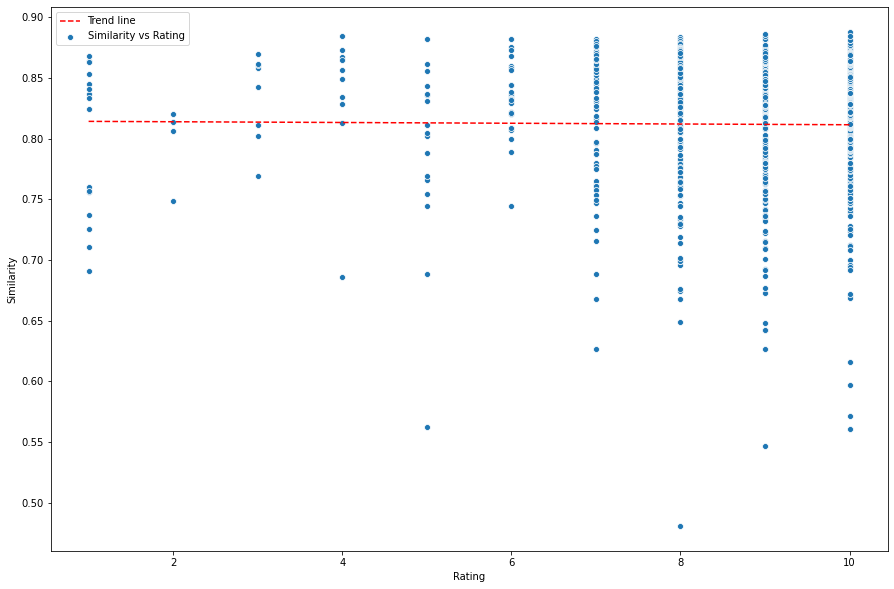

In [12]:
rating_sorted_reviews = review_df.sort_values(by='Rating')
plt.figure(figsize=(15,10))
sns.scatterplot(x = 'Rating', y = 'Similarity', data=rating_sorted_reviews)
x, y = rating_sorted_reviews['Rating'], rating_sorted_reviews['Similarity']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
legends = ['Trend line', 'Similarity vs Rating']
plt.legend(legends)
plt.show()

There isn't an observable trend, so it's difficult to say these two features are correlated.

## Average Rating

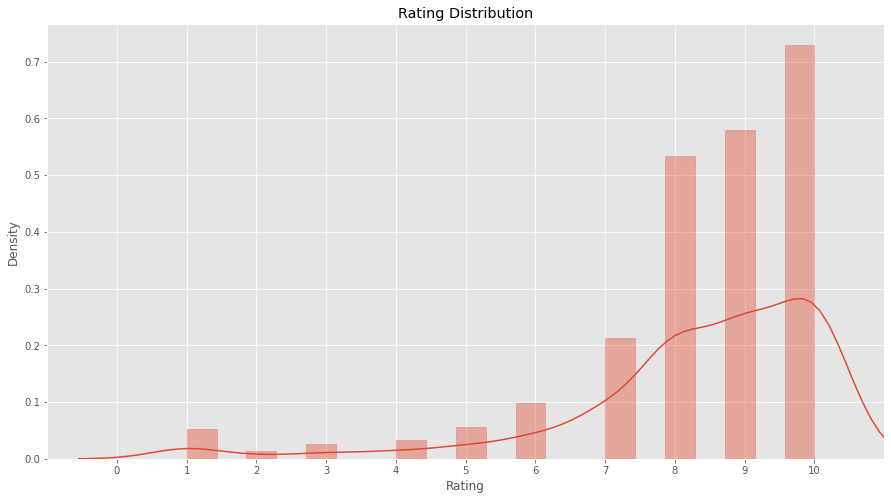

In [13]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 8]

sns.distplot(review_df['Rating'], hist_kws={"rwidth":5,'edgecolor':'red'})
plt.xlim(-1, 11)
plt.xticks(range(11))
plt.ylabel('Density')
plt.title('Rating Distribution')
plt.show()

In [14]:
review_df['Rating'] = review_df['Rating'].apply(lambda x: int(x))
print('Average rating of Train to Busan is {}'.format(round(review_df['Rating'].mean(), 2)))

Average rating of Train to Busan is 8.32


## Conclusion

* 5 most common words: movie, zombie, train, film, zombies
* There isn't a relationship between rating and similarity
* Most ratings are between 7 to 10
* Average rating of the movie is 8.32

## Observations

* BeautifulSoup can perform simple and basic web scraping, but Selenium is needed when you have to complete more complex tasks
* When counting common words, removing stop words is important
* Building word vectors become easier when you have a larger corpus
* Instead of comparing reviews to examine similarity, finding and scaling sentiments would've been more appropriate